In [1]:
# References: https://www.kaggle.com/code/erikbruin/riiid-comprehensive-eda-baseline#2.-Baseline-model

# LGBM Model simple

In [2]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype


DATA_DIR = '../milestone-04/data/'

users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR), index_col=0)
events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR), index_col=0)
subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)


In [3]:
import lightgbm as lgb
import math
import re


In [95]:
users.columns

Index(['learning_time_ms', 'start', 'end', 'logged_in_time_ms', 'language',
       'country'],
      dtype='object')

## Create time series
- Create column "week_sequential" -> Normalize dates to start at 1 for every student
- Join events and subtasks on event_id. Ignore subtasks not tied to an event


In [4]:
events[['Year', 'Week', 'Day']] = pd.to_datetime(events['start']).dt.isocalendar()
events['year_week'] = ((events['Year'] - 2015) * 53 + events['Week']).astype(int)
ts = events.reset_index().groupby(['user_id','year_week'])['event_id'].count().reset_index()
ts.rename(columns={'event_id':'num_events'}, inplace=True)

In [5]:
print(len(set(events.reset_index().event_id.unique()) - set(subtasks.event_id.unique())))
print("Some events have no subtasks")
print(len(set(subtasks.event_id.unique()) - set(events.reset_index().event_id.unique())))
print("There are no subtasks which don't correspond to an event")
print("We don't care about subtasks which don't have a coresponding event_id because we don't know what skill they are for")

427
Some events have no subtasks
0
There are no subtasks which don't correspond to an event
We don't care about subtasks which don't have a coresponding event_id because we don't know what skill they are for


In [6]:
events_and_substasks = events.reset_index().merge(subtasks.reset_index(), how='left', on=['event_id','user_id'], suffixes=('_event', '_subtask'))
events_and_substasks['date'] = pd.to_datetime(events_and_substasks['start'])
events_and_substasks[['Year', 'Week', 'Day']] = events_and_substasks['date'].dt.isocalendar()
events_and_substasks['year_week'] = (events_and_substasks['Year'] - 2015) * 53 + events_and_substasks['Week']
events_and_substasks['week_sequential'] = events_and_substasks.groupby('user_id')['year_week'].apply(lambda x: x - x.iat[0])

In [98]:
events_and_substasks = events_and_substasks.merge(users['country'], on='user_id')

In [7]:
task_events = events_and_substasks.query('type_event == "task" & correct != "nan"')

## Feature Selection
- Ignore categorical features with nulls for now

In [16]:
index = ['event_id','user_id']
cat_features = ['mode_event', 'game_name','number_range','skill_id', 'type_subtask']
cat_features_withnulls = [ 'destination', 'multiplier','operator','representation', 'solutionRepresentation', 'solveMode']
date_features = ['date','Year', 'Week', 'Day','week_sequential', 'year_week']
target_feature = ['correct']

In [64]:
df = task_events[index + cat_features + date_features + target_feature]

## Feature Engineering
- Create column "cumulative_percent_correct" - a feature for each student on their percentage correct so far (no data leakage from the future!)
- Create column "skill_cumulative_percent_correct" - a feature for each skill on the percentage this skill has been correct so far for all students (based on how many weeks have passed since the first datapoint)

In [65]:
df = df.sort_values(by='date')
df['correct'] = df['correct'].astype(int)

In [66]:
# Create a feature that represents the student's overall cumulative accuracy per skill
cumulative_percent_correct = df.groupby(['user_id','skill_id'],sort=False)['correct'].expanding(1).mean().reset_index().drop(columns=['user_id','skill_id']).rename(columns={'correct':'cumulative_percent_correct'})
df = df.merge(cumulative_percent_correct, left_index=True, right_on='level_2', how='left')

In [67]:
df_skills_mean = df.groupby(["skill_id", "year_week"]).mean()
df_skills_mean["skill_cumulative_percent_correct"] = df_skills_mean['correct'].expanding(1).mean()

In [68]:
# Create a feature that represent's a skill's overall cumulative correctness for all students
df_skills_mean = df_skills_mean.reset_index()[["skill_id","year_week","skill_cumulative_percent_correct"]]
df = df.merge(df_skills_mean, on=["skill_id","year_week"], how='left')

### Show graphs of the features created

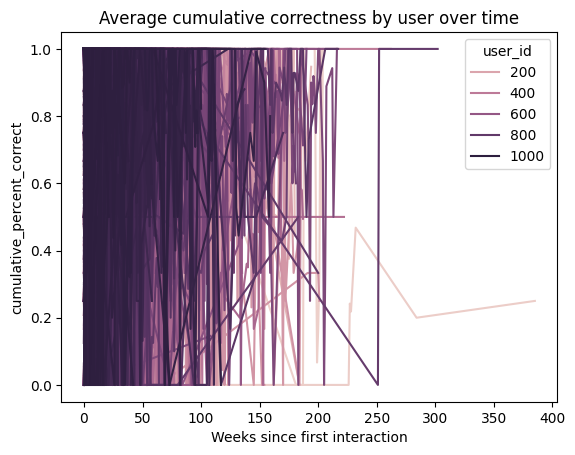

In [69]:
cumulative_correctness_avg_over_all_skills = df.groupby(['user_id','week_sequential']).mean()
sns.lineplot(
    data=cumulative_correctness_avg_over_all_skills.reset_index(),#.query('user_id < 10'), 
    x='week_sequential', 
    y='cumulative_percent_correct',
    hue='user_id'
)
plt.title("Average cumulative correctness by user over time")
plt.xlabel("Weeks since first interaction")

plt.savefig("cumulative_correctness_user.png")

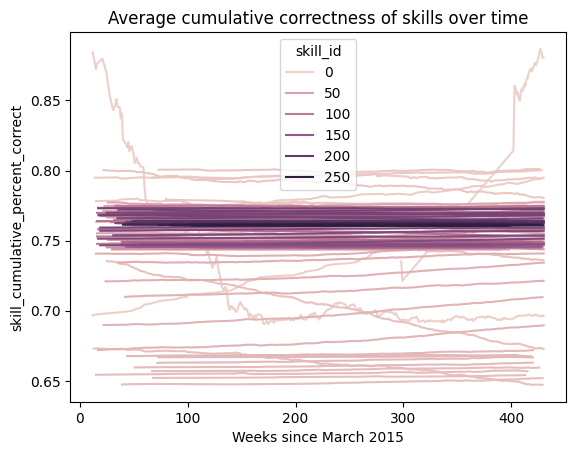

In [70]:
sns.lineplot(
    data=df_skills_mean.reset_index(),#.query('skill_id < 10'), 
    x='year_week', 
    y='skill_cumulative_percent_correct',
    hue='skill_id'
)
plt.title("Average cumulative correctness of skills over time")
plt.xlabel("Weeks since March 2015")

plt.savefig("cumulative_correctness_skill.png")

### One hot encode a feature for better explainability

In [20]:
# One hot encode a feature for better explainability

# Number range doesn't have big enough of an impact
# feature_to_encode = "number_range"
# one_hot_number_range = pd.get_dummies(df[feature_to_encode])
# df = df.drop(feature_to_encode, axis = 1)
# df = df.join(one_hot_number_range)
# cat_features.remove(feature_to_encode)

In [21]:
# feature_to_encode = "game_name"
# one_hot_game_name = pd.get_dummies(df[feature_to_encode])
# df = df.drop(feature_to_encode, axis = 1)
# df = df.join(one_hot_game_name)
# cat_features.remove(feature_to_encode)

In [22]:
# one_hot_col_names = [re.sub('[^A-Za-z0-9_]+', '', x) for x in one_hot_game_name.columns]

In [78]:
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [79]:
df

,event_id,user_id,mode_event,game_name,number_range,skill_id,type_subtask,date,Year,Week,Day,week_sequential,year_week,correct,level_2,cumulative_percent_correct,skill_cumulative_percent_correct
0,118,7,NORMAL,Subitizing,R10,1.0,ConciseTimeoutDescription,2015-03-19 18:48:57.303000+00:00,2015,12,4,0,12,1,135,1.000000,0.884277
1,118,7,NORMAL,Subitizing,R10,1.0,ConciseSubitizingTaskDescription,2015-03-19 18:48:57.303000+00:00,2015,12,4,0,12,1,134,1.000000,0.884277
2,119,7,NORMAL,Conversion,R10,3.0,ConciseConversionTaskDescription,2015-03-20 18:07:17.288000+00:00,2015,12,5,0,12,1,136,1.000000,0.696961
3,120,7,NORMAL,Landing,R10,19.0,ConciseLandingTaskDescription,2015-03-23 15:18:26.515000+00:00,2015,13,1,1,13,1,137,1.000000,0.673012
4,121,7,END_OF_NR,Conversion,R10,7.0,ConciseConversionTaskDescription,2015-04-02 14:03:06.836000+00:00,2015,14,4,2,14,1,138,1.000000,0.794868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55042,24597,644,END_OF_NR,Secret Number,R100,107.0,ConciseNumberInIntervalTaskDescription,2023-02-11 13:04:38.328000+00:00,2023,6,6,20,430,1,36904,0.777778,0.773379
55043,24597,644,END_OF_NR,Secret Number,R100,107.0,ConciseNumberInIntervalTaskDescription,2023-02-11 13:04:38.328000+00:00,2023,6,6,20,430,1,36903,0.789474,0.773379
55044,24597,644,END_OF_NR,Secret Number,R100,107.0,ConciseNumberInIntervalTaskDescription,2023-02-11 13:04:38.328000+00:00,2023,6,6,20,430,1,36907,0.800000,0.773379
55045,12966,318,END_OF_NR,Distance,R100,105.0,ConciseOrdinalityTaskDescription,2023-02-12 09:08:57.789000+00:00,2023,6,7,14,430,0,19918,0.000000,0.769139


In [80]:
# Check there are no nans
df.isna().sum()

event_id                            0
user_id                             0
mode_event                          0
game_name                           0
number_range                        0
skill_id                            0
type_subtask                        0
date                                0
Year                                0
Week                                0
Day                                 0
week_sequential                     0
year_week                           0
correct                             0
level_2                             0
cumulative_percent_correct          0
skill_cumulative_percent_correct    0
dtype: int64

In [81]:
# LGBM only accepts int, bool and float
for col in cat_features:
    # Convert categories into ints
    if col in df:
        df[col] = df[col].astype('category')
df['week_sequential'] = df['week_sequential'].astype('int32')
df[target_feature] = df[target_feature].astype('bool')

## Create train / validation / test split
- Split on user id (model should be evaluated on students it has never seen before)
- More sophisticated splitting on larger dataset


In [83]:
generated_features = ['cumulative_percent_correct', 'skill_cumulative_percent_correct']
one_hot_features = [] # one_hot_col_names
features = index + cat_features + generated_features + ['week_sequential'] + one_hot_features

train = df.query('user_id < 600')[features]
y_train = df.query('user_id < 600')[target_feature]

val = df.query('600 <= user_id < 800')[features]
y_val = df.query('600 <= user_id < 800')[target_feature]

test = df.query('user_id >= 800')[features]
y_test = df.query('user_id >= 800')[target_feature]

In [84]:
lgb_train = lgb.Dataset(train, y_train, categorical_feature = cat_features, free_raw_data=False)
lgb_eval = lgb.Dataset(val, y_val, categorical_feature = cat_features, free_raw_data=False)
lgb_test = lgb.Dataset(test, y_test, categorical_feature = cat_features, free_raw_data=False, reference=lgb_train)

## Build Model

In [85]:
params = {'objective': 'binary',
          'metric': 'auc',
          'seed': 0,
          'learning_rate': 0.1, #default
          "boosting_type": "gbdt" #default
          # 'num_leaves': 200,
          # 'feature_fraction': 0.75,
          # 'bagging_freq': 10,
          # 'bagging_fraction': 0.80
         }

In [86]:
%%time
model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=10000,
    early_stopping_rounds=8,
    keep_training_booster=True
)

/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 27719, number of negative: 6650
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1447
[LightGBM] [Info] Number of data points in the train set: 34369, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.806512 -> initscore=1.427501
[LightGBM] [Info] Start training from score 1.427501
Training until validation scores don't improve for 8 rounds


/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[15]	training's auc: 0.978191	valid_1's auc: 0.973256
CPU times: user 4.73 s, sys: 49.4 ms, total: 4.78 s
Wall time: 2.56 s


## Evaluate Model
- Compare performance per skill
- Look at feature importances (try SHAP in future)

In [87]:
overall_auc = model.eval(lgb_test, 'auc')
print(f"Overall AUC for test data is {overall_auc[0][2]}")

/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Overall AUC for test data is 0.9769513663578687


In [29]:
# Compare performance per skill
skills_dataset = {}

for skill in events['skill_id'].unique():
    if not math.isnan(skill):
        y_test = df.query(f'user_id >= 800 and skill_id == {skill}')[target_feature]
        skills_dataset[skill] = lgb.Dataset(test.query(f'skill_id == {skill}'), y_test, categorical_feature = cat_features, free_raw_data=False, reference=lgb_train)

In [ ]:
aucs ={}
for skill, dataset in skills_dataset.items():
    try:
        aucs[skill] = model.eval(dataset, 'auc')[0][2]
    except Exception as e:
        print(e)

Text(0, 0.5, 'AUC')

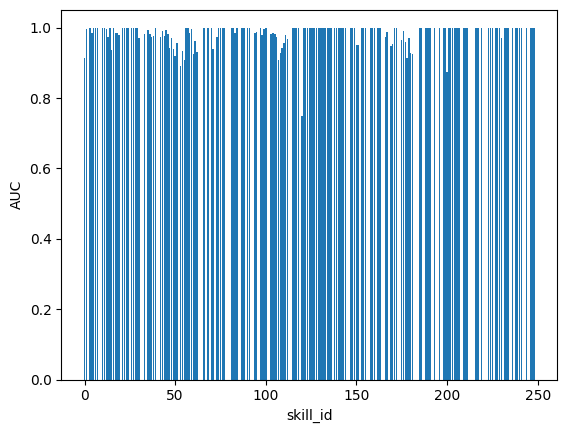

In [32]:
plt.bar(aucs.keys(), height=aucs.values())
plt.xlabel("skill_id")
plt.ylabel("AUC")

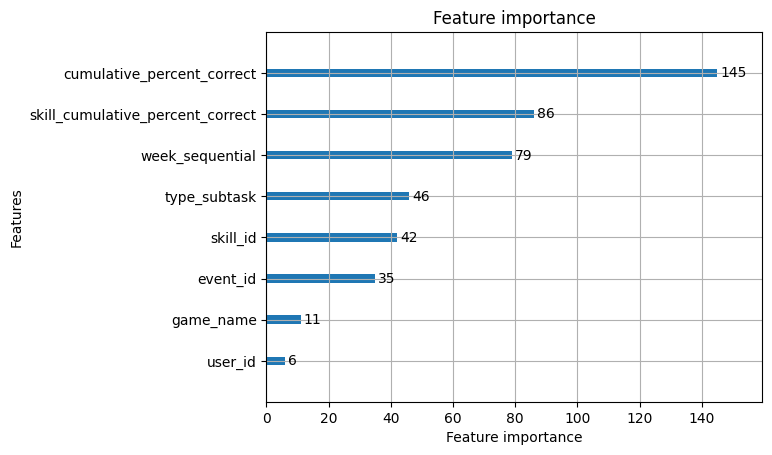

In [88]:
lgb.plot_importance(model)
plt.show()

## SHAP

https://www.kaggle.com/code/cast42/lightgbm-model-explained-by-shap

In [92]:
import shap

In [93]:
%time shap_values = shap.TreeExplainer(model).shap_values(test)


CPU times: user 2.79 s, sys: 18.1 ms, total: 2.81 s
Wall time: 1.4 s


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


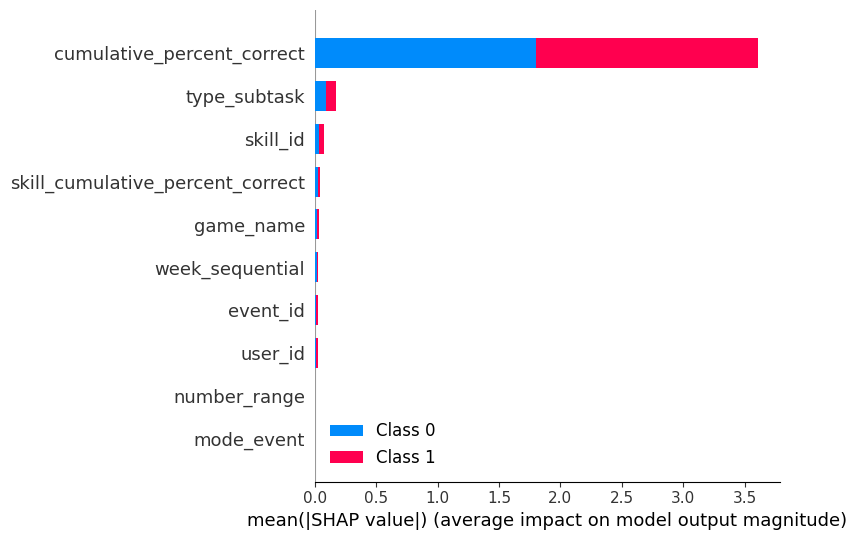

In [94]:
shap.summary_plot(shap_values, test)


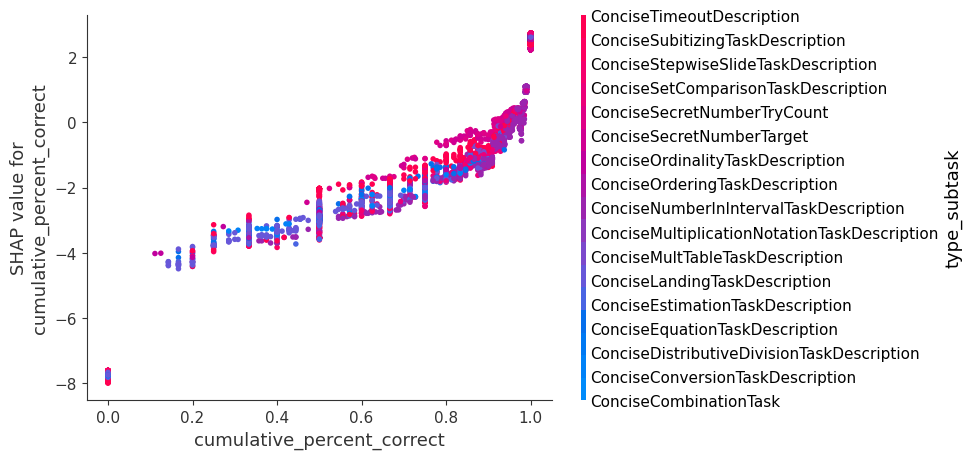

In [37]:
shap.dependence_plot("cumulative_percent_correct", shap_values[1], test)


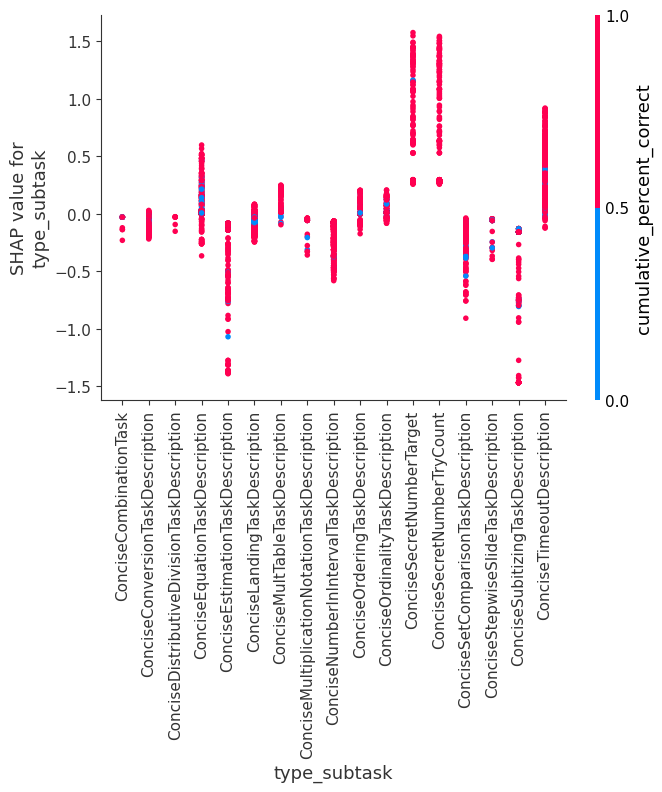

In [38]:
shap.dependence_plot("type_subtask", shap_values[1], test) # 1 is for predicting positive

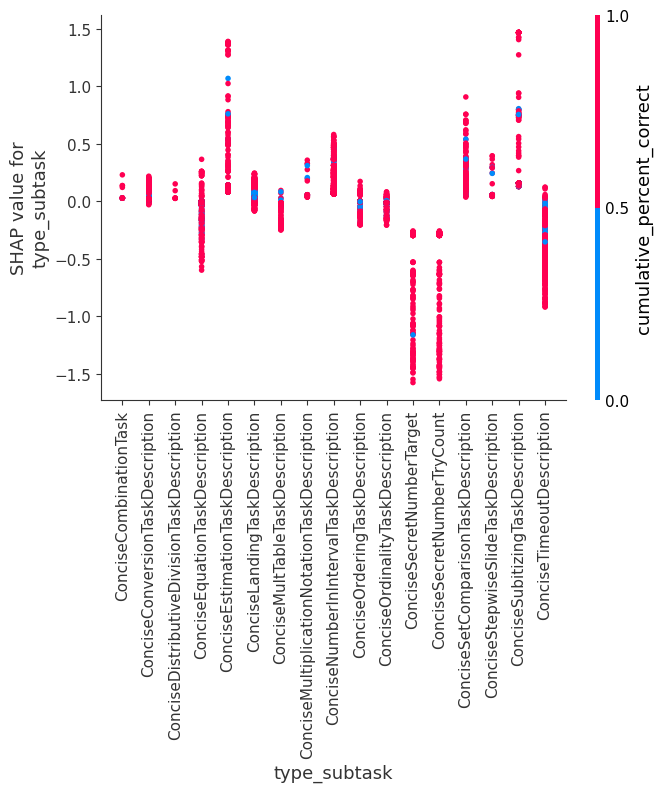

In [39]:
shap.dependence_plot("type_subtask", shap_values[0], test) # 0 is for predicting negative

## Other experiments

In [ ]:
# compute the split value histogram for the selected feature
hist, bin_edges = model.get_split_value_histogram('week_sequential', bins=50, xgboost_style=False)

# print the histogram and bin edges
print('Split value histogram for feature {}:'.format(0))
print('Bin edges:', bin_edges)
print('Histogram:', hist)

In [ ]:
# plot the histogram
plt.bar(bin_edges[:-1], hist, width=(bin_edges[1]-bin_edges[0])*0.7, align='edge')

# add labels and title
plt.xlabel('Split value')
plt.ylabel('Count')
plt.title('Split value histogram for feature {}'.format(0))

# display the plot
plt.show()

In [ ]:
# Notes
# Split on students never seen before
# Train on all, evaluate on one skill at a time (why does the model perform bettwe for certain skills)
# Categorical features -> one hot might be more explainable
    # Performance is typically better with integer encoding
# Plot each skill forecast ?
# LSTM (watch lecture), Transformer (need lots of data)
# Lime explainability

In [ ]:
# Optuna for hpt tuning
# https://www.kaggle.com/code/isaienkov/riiid-answer-correctness-prediction-eda-modeling